# Anomaly detection
### Classification on imbalanced data using tensorflow

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div> 

<div style="text-align: right"> Initial upload: 2020.09.07 </div> 
<div style="text-align: right"> Last update: 2020.09.07</div> 

tensorflow를 활용한 클래스 불균형 문제 해결 방안에 대하여 소개한다.  
캐글의 신용카드 사기거래 탐지([Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud)) 데이터셋을 사용한다.

참고자료
- https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

## 1. 데이터셋 확인

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import datetime
import missingno as msno
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 30

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
color_pal = [ '#ee4035', '#3385c6', '#fed766','#eb6841', '#708090', '#00a0b0', '#3b7dd8', '#fe4a49' , 
             '#2ab7ca', '#851e3e', '#2a4d69',  '#f7f7f7', '#edc951', '#54b2a9', '#ffffff', '#96ceb4', 
             '#ffeead', '#708090', '#be9b7b', '#feb2a8','#58668b',  '#4f372d', '#ECD59F', '#ABD1DC', 
             '#7E9680', '#E69D45', '#D4CFC9', '#E79796', '#C6C09C', '#dec3c3','#4b86b4', '#f9caa7', 
             '#d2d4dc', '#ebf4f6', '#29a8ab' ]

In [4]:
data = pd.read_csv('data/creditcard.csv')

데이터셋을 간단하게 살펴본다.

In [5]:
data.shape

(284807, 31)

In [6]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,...,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,...,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,...,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,...,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,...,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,...,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
# 일부만 살펴본다.
data[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


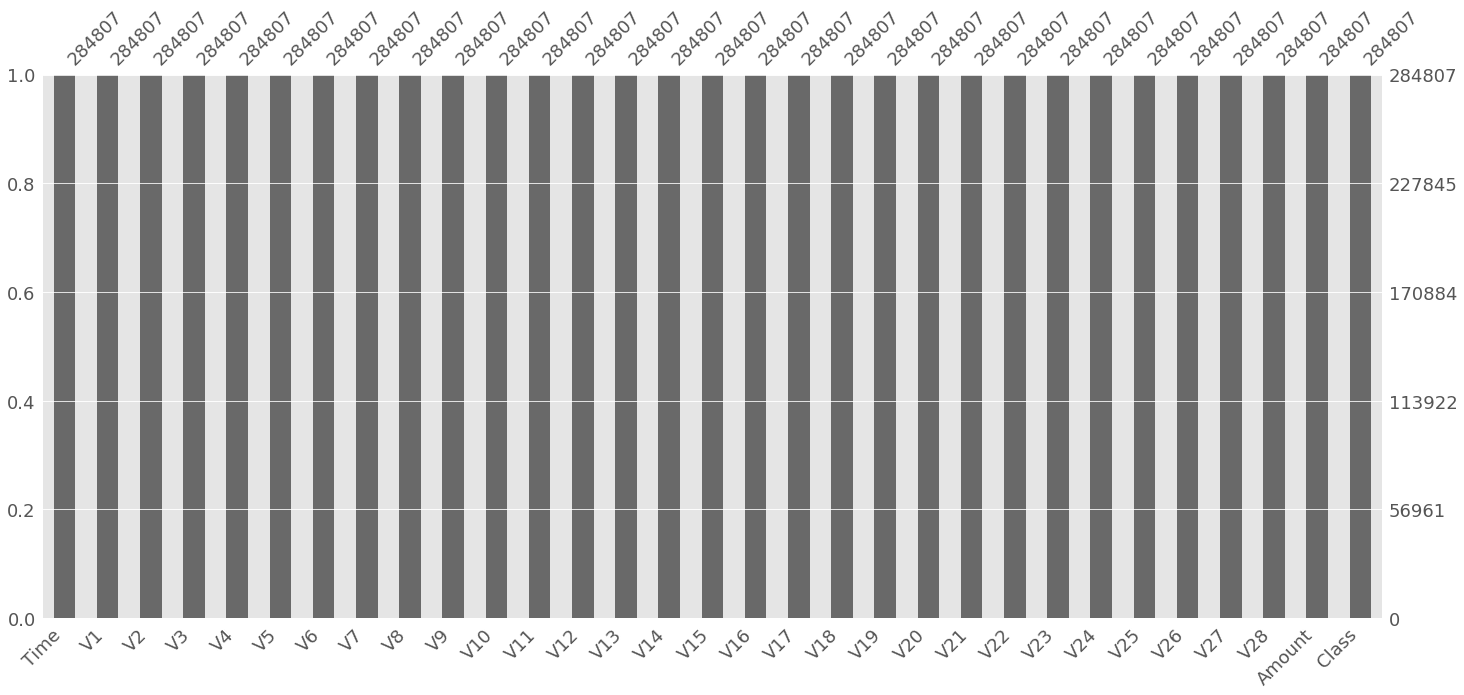

In [8]:
# 결측치 확인
msno.bar(data, fontsize = 18)
plt.show()

In [9]:
data.isnull().sum().any()

False

- 결측치 없음

## 2. EDA 및 전처리

우선 데이터셋을 복사해둔다.

In [10]:
cleaned_df = data.copy()

### 2.1 Class
`Class` 값은 0(정상) 또는 1(사기) 중에 한가지 값을 가진다.  
`Class` 값의 분포를 확인해본다.  

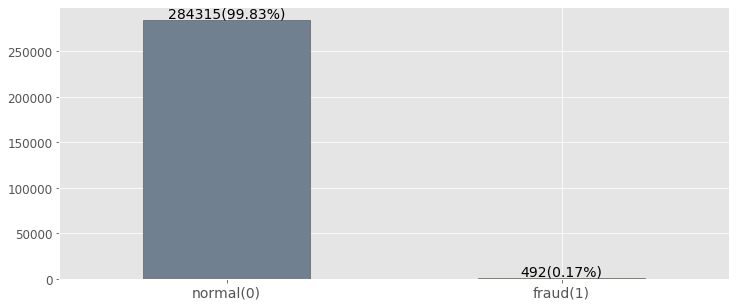

In [11]:
fig, ax = plt.subplots(figsize = (12, 5))
data['Class'].value_counts().plot(kind = 'bar', color = color_pal[17:], 
                        edgecolor='#404040', ax = ax, fontsize = 12, rot = 0)

for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2., p.get_height()+3000, 
            str(p.get_height())+'('+str(round((p.get_height()/data.shape[0])*100,
            2))+ '%)', ha='center', fontsize = 14)

ax.set_xticklabels(['normal(0)', 'fraud(1)'], fontsize = 14)
plt.show()

class분포를 확인하는 다른 방법

In [12]:
neg, pos = np.bincount(data['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



### 2.2 Time
거래시간 Time은 실수형 데이터이다.

**히스토그램으로 분포 확인**

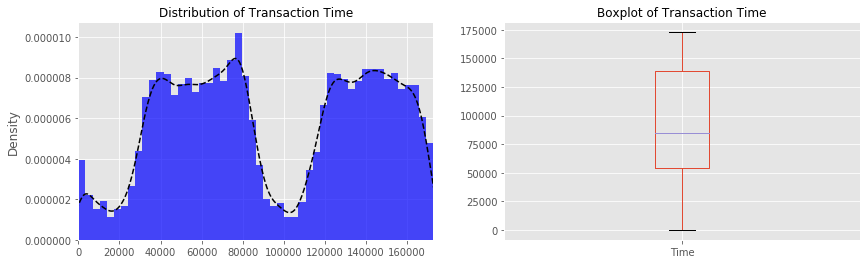

In [13]:
fig, axes = plt.subplots(1, 2, figsize = (14, 4))

time_val = data['Time'].values

data['Time'].plot(kind = 'hist',bins = 50, ax = axes[0], density = True, alpha = 0.7,
                  color = 'b', fontsize = 10, rot = 0)
data['Time'].plot(kind = 'kde', style = 'k--', ax = axes[0])
axes[0].set_title('Distribution of Transaction Time', fontsize=12)
axes[0].set_xlim([min(time_val), max(time_val)])

data[['Time']].boxplot(ax = axes[1], fontsize = 10, rot = 0)
axes[1].set_title('Boxplot of Transaction Time', fontsize=12)
plt.show()

**Time-Class 상관도 분석**

먼저 정상데이터(Class ==0)와 이상데이터를 구분한다.(Class==1)

In [14]:
Fraud = data[data['Class']==1]
Normal = data[data['Class']==0]

시간대별 정상, 비정상 데이터의 scatter plot을 그려본다.

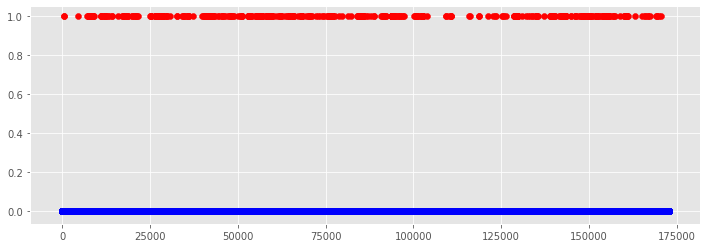

In [15]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.scatter(Normal['Time'], Normal['Class'], color = 'b', alpha = 0.6)
ax.scatter(Fraud['Time'], Fraud['Class'], color = 'r')
plt.show()

정상, 비정상 데이터를 구분하여 시간분포를 그려본다.

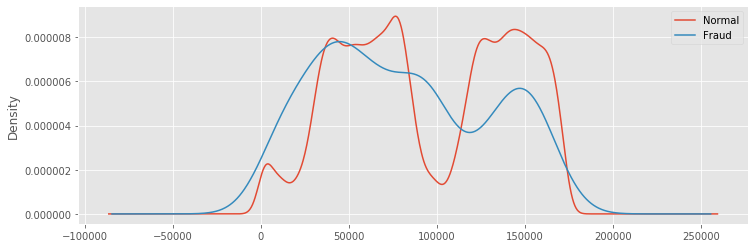

In [16]:
fig, ax = plt.subplots(figsize = (12, 4))

time_val = data['Time'].values

Normal['Time'].plot(kind = 'kde', ax = ax)
Fraud['Time'].plot(kind = 'kde', ax = ax)
plt.xticks(rotation = 0)
ax.legend(['Normal', 'Fraud'])
#ax.set_xlim([min(time_val), max(time_val)])
plt.show()

- 특별한 상관성이 확인되지 않는다.
- 사기거래의 경우, 비교적 짧은 시간에 거래가 이루어지고 있다. 하지만 그 시간대에 정상거래의 비중도 높다.

Time 컬럼을 제거한다.

In [17]:
cleaned_df.pop('Time')

0              0.0
1              0.0
2              1.0
3              1.0
4              2.0
            ...   
284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, Length: 284807, dtype: float64

In [18]:
cleaned_df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

### 2.3 Amount
- 거래대금 Amount는 실수형 데이터이다.

**히스토그램으로 분포 확인.**

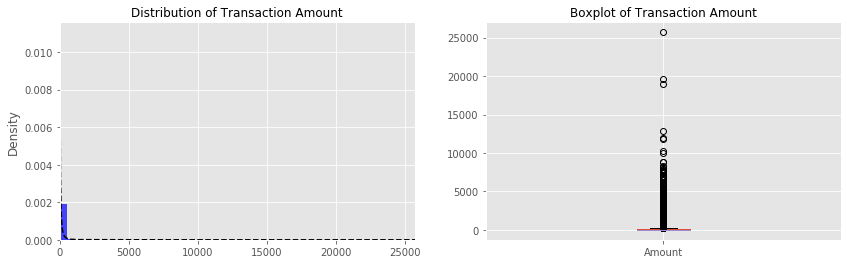

In [19]:
fig, axes = plt.subplots(1, 2, figsize = (14, 4))

time_val = data['Amount'].values

data['Amount'].plot(kind = 'hist',bins = 50, ax = axes[0], density = True, alpha = 0.7,
                  color = 'b', fontsize = 10, rot = 0)
data['Amount'].plot(kind = 'kde', style = 'k--', ax = axes[0])
axes[0].set_title('Distribution of Transaction Amount', fontsize=12)
axes[0].set_xlim([min(time_val), max(time_val)])

data[['Amount']].boxplot(ax = axes[1], fontsize = 10, rot = 0)
axes[1].set_title('Boxplot of Transaction Amount', fontsize=12)
plt.show()

- 식별이 잘 안되므로 log scale로 변경하여 확인한다.

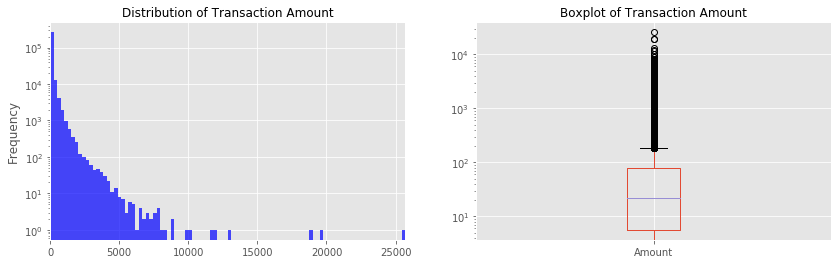

In [20]:
fig, axes = plt.subplots(1, 2, figsize = (14, 4))

time_val = data['Amount'].values

data['Amount'].plot(kind = 'hist',bins = 100, ax = axes[0], alpha = 0.7,
                  color = 'b', fontsize = 10, rot = 0)
axes[0].set_title('Distribution of Transaction Amount', fontsize=12)
axes[0].set_xlim([min(time_val), max(time_val)])
axes[0].set_yscale('log')
data[['Amount']].boxplot(ax = axes[1], fontsize = 10, rot = 0)
axes[1].set_title('Boxplot of Transaction Amount', fontsize=12)
axes[1].set_yscale('log')
plt.show()

- 값이 넓은 범위에 분포되어 있으며, 작은 금액대(5000 이하)에 집중되어 있다.
- 스케일 조정이 필요해 보인다.

**Amount-Class 상관도 분석**

정상, 비정상 데이터의 거래금액(Amount)의 scatter plot을 그려본다.

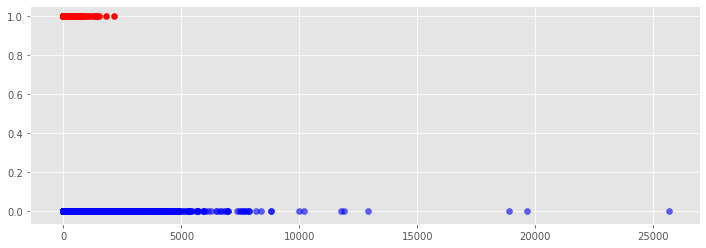

In [21]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.scatter(Normal['Amount'], Normal['Class'], color = 'b', alpha = 0.6)
ax.scatter(Fraud['Amount'], Fraud['Class'], color = 'r')
plt.show()

**Log 변환**

`Amount` 컬럼을 log 변환한다.

In [22]:
eps=0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

In [23]:
cleaned_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Log Ammount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989913
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936641
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.816249
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.248367


### 2.4 V1 ~ 28

나머지 피처들의 피어슨 상관도를 살펴본다.

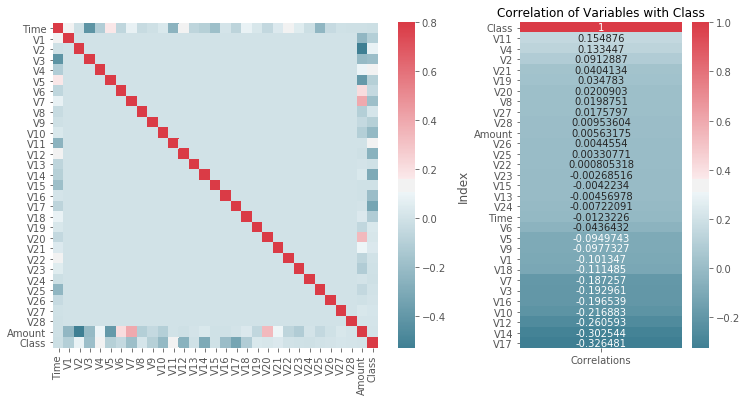

In [24]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6), gridspec_kw={'width_ratios': [2, 1]})
corr = data.corr()

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, vmax = 0.8, square = True, cmap =cmap, ax = axes[0])

corr = data.corrwith(data['Class']).reset_index()
corr.columns = ['Index','Correlations']
corr = corr.set_index('Index')
corr = corr.sort_values(by=['Correlations'], ascending = False)
sns.heatmap(corr, annot=True, fmt="g", cmap=cmap, ax = axes[1])
axes[1].set_title("Correlation of Variables with Class", fontsize = 12)
plt.subplots_adjust(wspace = 0.2)
plt.show()

### 2.5 데이터 나누기

테스트 데이터는 평가에만 사용하기 위해 따로 뺀다.  
train, val, test 용으로 나눈다.

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

In [27]:
# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

In [28]:
bool_train_labels

array([False, False, False, ..., False, False, False])

In [29]:
train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

### 2.6 스케일링  
데이터를 정규화한다.

In [30]:
from sklearn.preprocessing import StandardScaler

In [31]:
scaler = StandardScaler()

In [32]:
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

### 2.7 이상치(outlier) 제거  
특정범위를 이탈하는 데이터셋을 제거한다.

In [33]:
# 기준 범위 내의 샘플만 추출: qualtile과 유사
np.clip(train_features, -5, 5)[0]

array([-0.57154648, -0.40090004,  0.74313508,  1.23613813,  0.79386738,
       -0.46346268,  0.05620372,  0.09673429, -0.21019583, -0.16389733,
       -0.68122015,  0.25601281, -0.09107166,  0.13245788,  0.19317479,
       -1.40251654,  0.72145262, -0.71048414,  0.84203053,  0.64474501,
        0.29763771,  0.5101467 ,  0.72297586,  0.13948634, -1.08276449,
       -0.69452572,  0.44522355,  0.74390387,  0.83821804])

범위 내의 데이터셋만 저장한다.

In [34]:
train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

In [35]:
print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


### 2.8 데이터 분포 살펴보기

In [36]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = train_df.columns)

In [37]:
pos_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Log Ammount
0,0.612814,0.825902,-0.450253,2.210167,0.474335,-0.895480,0.327130,-0.218340,0.375774,-0.794303,1.101204,-3.802395,0.370966,-1.026171,-0.013988,1.674264,3.107746,1.545985,-1.924546,-0.250070,-0.520986,-1.226481,-0.127138,0.058886,1.061352,-0.056431,-0.060822,0.237379,-0.889474
1,-1.857640,2.786930,-4.196555,4.398982,-4.287943,-1.873136,-5.000000,2.415014,-5.000000,-5.000000,5.000000,-5.000000,0.190923,-5.000000,-0.368957,-5.000000,-5.000000,-5.000000,0.968309,1.848684,3.125905,0.858121,-0.160225,0.886508,0.767460,0.017206,5.000000,2.678956,-0.793647
2,0.234200,0.847359,-0.324571,1.984763,1.308765,0.075406,1.066856,-0.117876,-1.546488,0.880966,-1.672187,-0.245775,0.459945,0.145461,-2.067923,0.425558,-0.949692,-0.833041,-1.842532,-0.355997,0.146041,0.513434,0.081629,0.663296,-1.397483,-0.421443,0.234608,0.305777,-4.854071
3,0.972187,0.661947,-1.111341,2.953390,0.748229,-0.007627,-0.066288,0.052861,-0.651203,0.038399,-0.402576,-0.941506,0.060000,-3.705156,-0.178919,2.378790,2.062856,1.891416,-2.873541,-0.207453,0.281539,1.014150,-0.064417,0.552316,0.283592,0.580752,0.082014,0.116534,-0.873934
4,-0.739309,-0.494680,0.742181,0.274274,-0.205823,-0.042186,1.092587,0.165271,-0.498270,-0.659175,1.248956,0.020418,-1.528948,0.765027,0.183394,0.397549,-0.673840,0.259074,-1.403600,0.845474,0.449777,0.020679,1.404142,0.190172,0.301318,-1.286781,-0.301697,0.115608,1.442242


In [38]:
import seaborn as sns

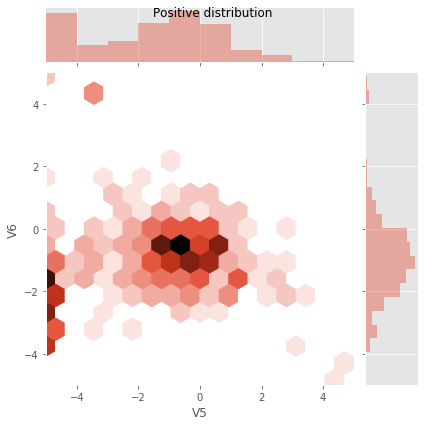

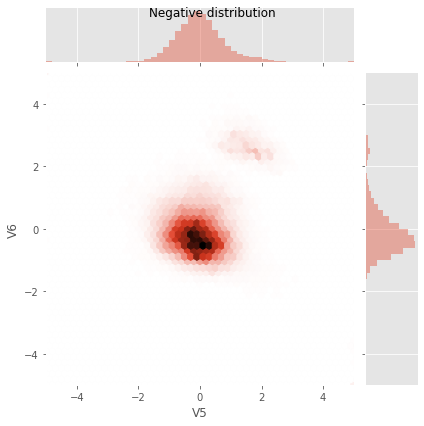

In [39]:
sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
_ = plt.suptitle("Negative distribution")

- 정규화 처리를 했음에도 이상거래(positive)에서 ['V5]의 중심이 0이 아닌 것을 확인할 수 있다. 

## 3. 모델 및 메트릭 정의

In [40]:
import itertools
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontsize = 16)
    plt.yticks(tick_marks, classes, fontsize = 16)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", 
                 fontsize = 18)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [42]:
METRICS = [TruePositives(name='tp'), FalsePositives(name='fp'), 
           TrueNegatives(name='tn'), FalseNegatives(name='fn'), 
           BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'),
           AUC(name='auc'),]

In [43]:
def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        # 상수로 텐서를 생성하는 이니셜라이져, 클래스 불균형에 적용가는
        
    model = keras.Sequential([Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
                              Dropout(0.5),
                              Dense(1, activation='sigmoid', bias_initializer=output_bias),
                             ])

    model.compile(optimizer=Adam(lr=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

    return model

In [44]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = EarlyStopping(monitor='val_auc', verbose=1, patience=10, mode='max',
                               restore_best_weights=True)

In [45]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


## 4. 모델 학습 및 평가

### 4.1 학습이 안된 모델

일단 학습을 시키지 않고 예측해본다.

In [46]:
model.predict(train_features[:10])

array([[0.29038912],
       [0.21766068],
       [0.45118585],
       [0.3867934 ],
       [0.28447986],
       [0.35670492],
       [0.26366195],
       [0.49151805],
       [0.7373983 ],
       [0.19207567]], dtype=float32)

결과 평가하기

In [47]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.5574


In [48]:
results

[0.5573792457580566,
 129.0,
 42282.0,
 139696.0,
 169.0,
 0.7671059370040894,
 0.00304166367277503,
 0.43288591504096985,
 0.656733512878418]

- 첫번째 인자가 loss이고 나머지는 앞에 metric에서 지정한 인자이다.

### 4.2 학습이 안된 모델 : 바이어스만 조정한 모델  
마지막 레이터에 클래스의 비율을 고려해 바이어스를 지정한다.  
바이어스를 지정한 것 만으로 loss가 얼마나 개선되는지 확인해보자.

In [49]:
initial_bias = np.log([pos/neg])
initial_bias
# 설정근거 : https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

array([-6.35935934])

In [50]:
pos / total

0.001727485630620034

pos/total = 0.0018 이므로 더 합리적인 추측이 될 것이다.

In [51]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])

array([[0.00149749],
       [0.00071867],
       [0.0017012 ],
       [0.00089507],
       [0.00155636],
       [0.00075479],
       [0.00223226],
       [0.00025394],
       [0.00026032],
       [0.00117008]], dtype=float32)

In [52]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0151


모델 저장하기

In [53]:
import tempfile
import os

In [54]:
initial_weights = './weights/initial_weights'
model.save_weights(initial_weights)

In [55]:
initial_weights

'./weights/initial_weights'

바이어스가 성능에 도움이 되었는지 확인해보자

In [56]:
model = make_model()
model.load_weights(initial_weights)

먼저 마지막 레이어에 바이어스를 가하지 않고 학습시켜본다.

In [57]:
model.layers[-1].bias.assign([0.0])

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>

In [58]:
zero_bias_history = model.fit(train_features, train_labels, batch_size=BATCH_SIZE, 
                              epochs=20, validation_data=(val_features, val_labels), verbose=0)

다음은 바이어스를 가한후 학습한다.

In [59]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(train_features, train_labels, batch_size=BATCH_SIZE, 
                                 epochs=20, validation_data=(val_features, val_labels), verbose=0)

In [60]:
zero_bias_history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [61]:
zero_bias_history.history

{'loss': [0.3372684419155121,
  0.1724422425031662,
  0.10905015468597412,
  0.07647435367107391,
  0.056719306856393814,
  0.045747362077236176,
  0.036970917135477066,
  0.03190542012453079,
  0.027879392728209496,
  0.025020601227879524,
  0.021874206140637398,
  0.02061573788523674,
  0.01886281929910183,
  0.017666159197688103,
  0.01593891903758049,
  0.015660719946026802,
  0.014503459446132183,
  0.013631940819323063,
  0.013146145269274712,
  0.01253826729953289],
 'tp': [173.0,
  44.0,
  56.0,
  80.0,
  106.0,
  113.0,
  150.0,
  146.0,
  142.0,
  147.0,
  166.0,
  155.0,
  162.0,
  159.0,
  167.0,
  158.0,
  161.0,
  174.0,
  180.0,
  170.0],
 'fp': [61817.0,
  4005.0,
  1292.0,
  583.0,
  270.0,
  174.0,
  114.0,
  82.0,
  67.0,
  64.0,
  44.0,
  48.0,
  42.0,
  34.0,
  33.0,
  26.0,
  31.0,
  31.0,
  28.0,
  30.0],
 'tn': [484117.0,
  177973.0,
  180686.0,
  181395.0,
  181708.0,
  181804.0,
  181864.0,
  181896.0,
  181911.0,
  181914.0,
  181934.0,
  181930.0,
  181936.0

In [62]:
def plot_loss(history, label, n):
    # plt.figure(figsize = (12, 5))
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()

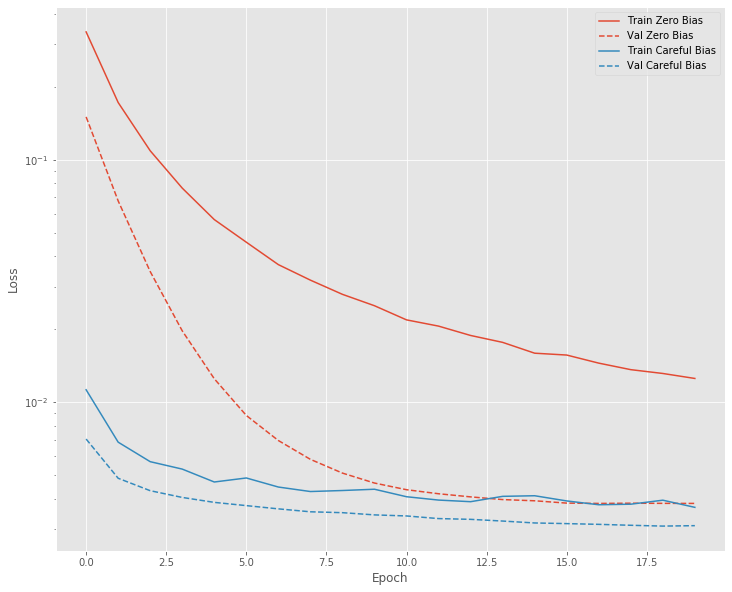

In [63]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

- loss 측면에서 bias를 설정하는 것이 유리함을 보여준다.

### 4.3 Baseline 모델 : 학습된 모델

In [64]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(train_features, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS,
                             callbacks = [early_stopping], validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 2s 24ms/step - loss: 0.0123 - tp: 76.7692 - fp: 9.4725 - tn: 139469.1648 - fn: 154.1648 - accuracy: 0.9989 - precision: 0.8910 - recall: 0.3775 - auc: 0.7735 - val_loss: 0.0064 - val_tp: 22.0000 - val_fp: 5.0000 - val_tn: 45477.0000 - val_fn: 65.0000 - val_accuracy: 0.9985 - val_precision: 0.8148 - val_recall: 0.2529 - val_auc: 0.9131
Epoch 2/100
90/90 [==============================] - 1s 6ms/step - loss: 0.0077 - tp: 59.1978 - fp: 9.5934 - tn: 93970.4505 - fn: 101.3297 - accuracy: 0.9988 - precision: 0.8575 - recall: 0.3534 - auc: 0.8233 - val_loss: 0.0048 - val_tp: 41.0000 - val_fp: 6.0000 - val_tn: 45476.0000 - val_fn: 46.0000 - val_accuracy: 0.9989 - val_precision: 0.8723 - val_recall: 0.4713 - val_auc: 0.9192
Epoch 3/100
90/90 [==============================] - 1s 6ms/step - loss: 0.0066 - tp: 62.4835 - fp: 12.0110 - tn: 93976.6923 - fn: 89.3846 - accuracy: 0.9989 - precision: 0.8401 - recall: 0.3839 - auc: 0.8773 - val_loss: 0

학습결과 시각화

In [65]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

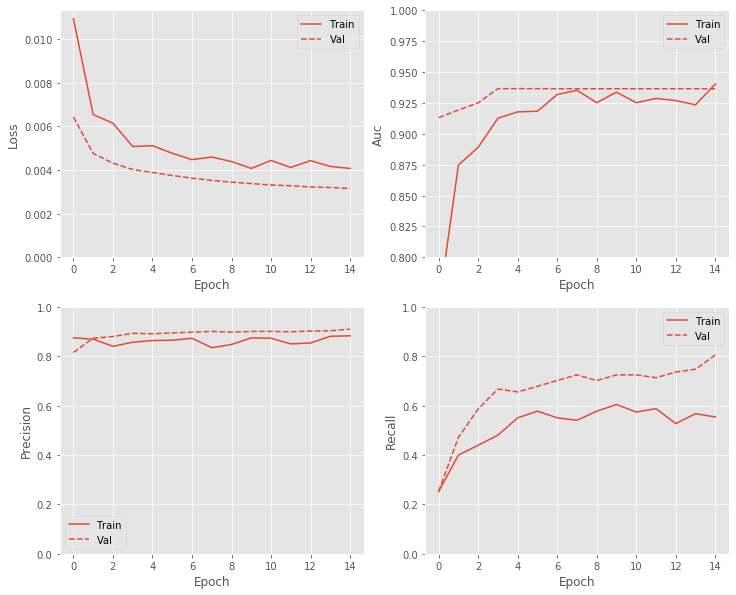

In [66]:
plot_metrics(baseline_history)

- 위에서 보면 train보다 val에서 성능이 더 좋은 것을 볼 수가 있는데,
- 이것은 **학습 모델에서 dropout을 사용했기 때문이다.**  
- dropout은 val에서는 적용이 되지 않는다.

메트릭 평가

In [67]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [68]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

loss :  0.005065471865236759
tp :  71.0
fp :  18.0
tn :  56837.0
fn :  36.0
accuracy :  0.9990519881248474
precision :  0.7977527976036072
recall :  0.663551390171051
auc :  0.8921216130256653



In [69]:
test_labels.shape

(56962,)

In [70]:
test_predictions_baseline

array([[3.1911780e-04],
       [8.9098234e-04],
       [5.1571749e-04],
       ...,
       [1.0966722e-04],
       [4.0189002e-04],
       [6.8482725e-05]], dtype=float32)

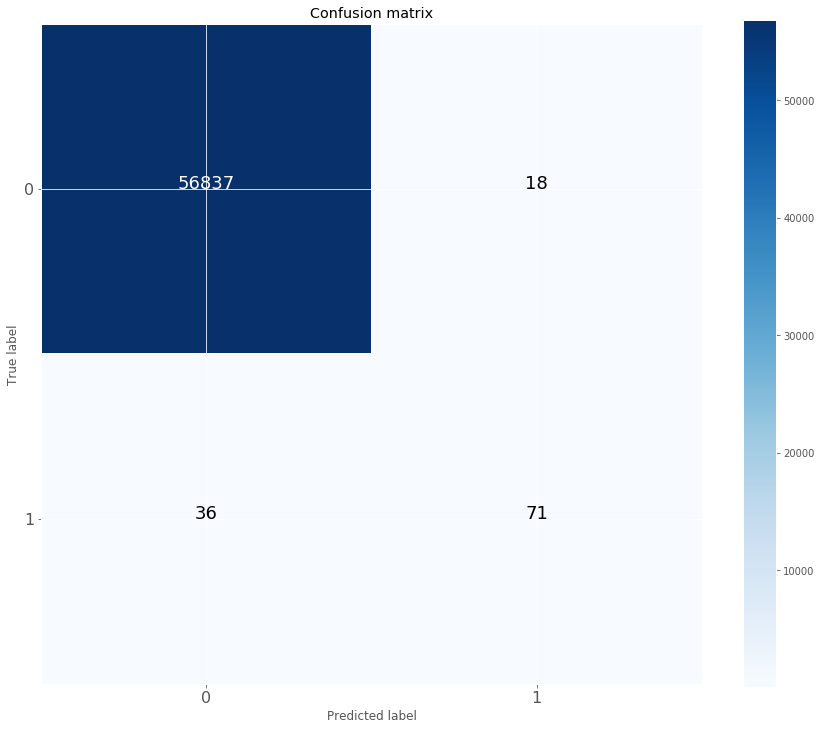

In [71]:
conf_mat = confusion_matrix(test_labels, test_predictions_baseline.flatten()>= 0.5)
class_names = [0,1]
plot_confusion_matrix(conf_mat , classes=class_names,
                      title='Confusion matrix')
plt.show()

ROC(Receiver Operator Curves) 그리기  
- 학습 데이터, 시험 데이터에 대한 정확도를 시각적으로 표현해보자

In [72]:
from sklearn.metrics import roc_curve

In [73]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

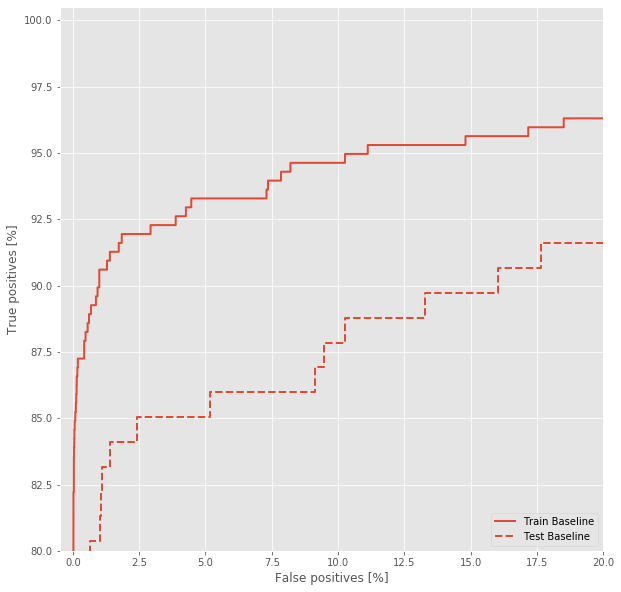

In [74]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

- 정밀도(Precision)는 비교적 높은 것처럼 보이지만 재현율(Recall)과 ROC 곡선 아래 영역 (AUC)은 원하는만큼 높지 않다.  
- 분류기 설계할 때 정밀도와 재현율을 모두 극대화하려고 할 것이다.
- 그런데 불균형 데이터 세트로 작업 할 때 어려움이 있다.
- 이때에는 관심있는 문제의 맥락에서 다양한 유형의 오류 비용을 고려하는 것이 중요하다.
- 이 예에서 False negative(사기 거래 누락)는 재정적 비용이있을 수있는 반면, False positive(거래가 사기로 잘못 표시됨)은 사용자의 행복을 감소시킬 수 있다.

### 4.4 클래스 가중치를 부여하여 모델을 학습시키기

positive 샘플이 많지 않으므로 분류자가 가중치를 다르게 설정할 수 있다. 모델의 매개 변수를 통해 각 클래스에 대한 Keras 가중치를 조정하여 과소 표현 된 클래스의 예제에 "더 많은주의를 기울이게" 할 수가 있다.

클래스 가중치에 대한 정보를 딕셔너리로 저장한다.

In [75]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


클래스에 가중치를 부여하여 모델을 학습시킨다.

In [76]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(train_features, train_labels, batch_size=BATCH_SIZE, 
                                      epochs=EPOCHS, callbacks = [early_stopping],
                                      validation_data=(val_features, val_labels),
                                      # The class weights go here
                                      class_weight=class_weight) 

Epoch 1/100
90/90 [==============================] - 2s 24ms/step - loss: 2.8230 - tp: 85.3736 - fp: 19.0879 - tn: 150828.8901 - fn: 169.2198 - accuracy: 0.9988 - precision: 0.8141 - recall: 0.3680 - auc: 0.7680 - val_loss: 0.0063 - val_tp: 32.0000 - val_fp: 5.0000 - val_tn: 45477.0000 - val_fn: 55.0000 - val_accuracy: 0.9987 - val_precision: 0.8649 - val_recall: 0.3678 - val_auc: 0.9143
Epoch 2/100
90/90 [==============================] - 1s 6ms/step - loss: 1.4021 - tp: 66.0549 - fp: 21.6154 - tn: 93963.4505 - fn: 89.4505 - accuracy: 0.9988 - precision: 0.7905 - recall: 0.3909 - auc: 0.8544 - val_loss: 0.0061 - val_tp: 61.0000 - val_fp: 7.0000 - val_tn: 45475.0000 - val_fn: 26.0000 - val_accuracy: 0.9993 - val_precision: 0.8971 - val_recall: 0.7011 - val_auc: 0.9606
Epoch 3/100
90/90 [==============================] - 1s 6ms/step - loss: 0.7352 - tp: 89.4835 - fp: 96.9121 - tn: 93891.8791 - fn: 62.2967 - accuracy: 0.9984 - precision: 0.4672 - recall: 0.5842 - auc: 0.9121 - val_loss: 

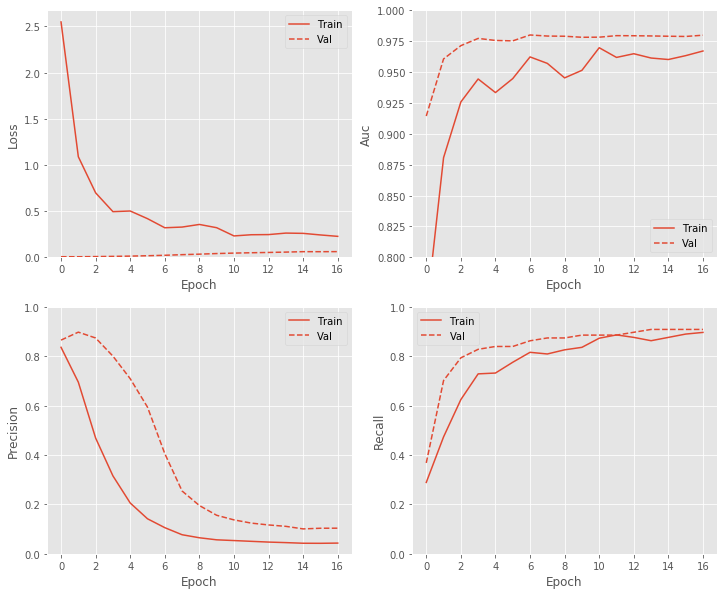

In [77]:
plot_metrics(weighted_history)

매트릭 평가

In [78]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

In [79]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

loss :  0.025288378819823265
tp :  84.0
fp :  164.0
tn :  56691.0
fn :  23.0
accuracy :  0.996717095375061
precision :  0.33870968222618103
recall :  0.7850467562675476
auc :  0.9623168706893921



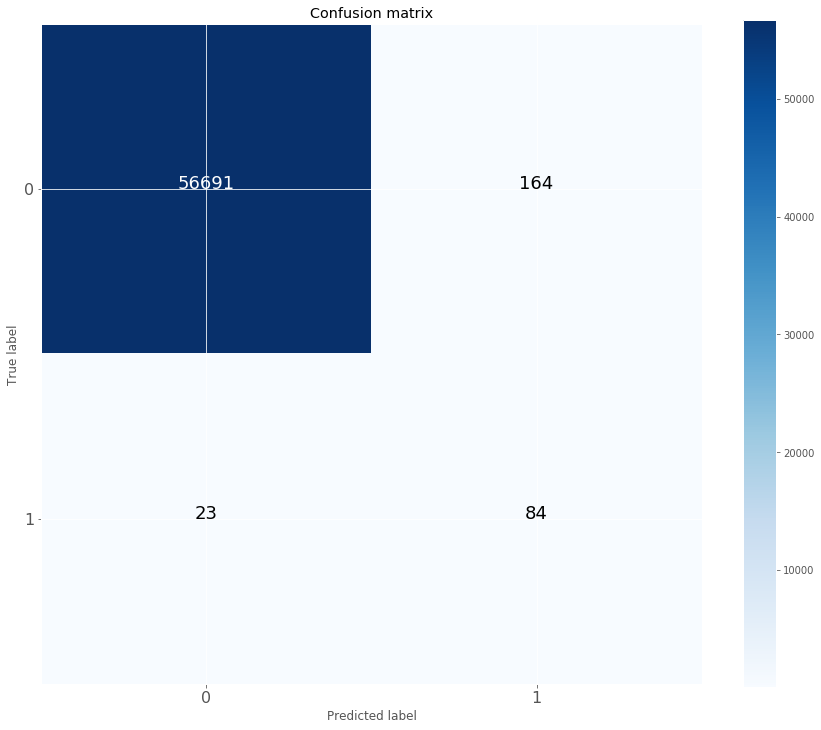

In [80]:
conf_mat = confusion_matrix(test_labels, test_predictions_weighted.flatten()>= 0.5)
class_names = [0,1]
plot_confusion_matrix(conf_mat , classes=class_names,
                      title='Confusion matrix')
plt.show()

- 클래스 가중치를 사용하면 False positive가 늘어났다.
- positive가 더 많기 때문에 accuracy와 precision이 낮아졌다.
- 그러나 더 많은 True positive를 발견했기 때문에 recall과 AUC가 더 높아졌다.
- accuracy가 낮음에도 불구하고이 모델은 더 높은 recall을 제공하며 더 많은 사기 거래를 식별한다.
- 물론 두 가지 유형의 오류 모두에서 비용이 발생한다.
- 실제적인 비용을 고려하여 절충점을 결정해야 할 것이다.

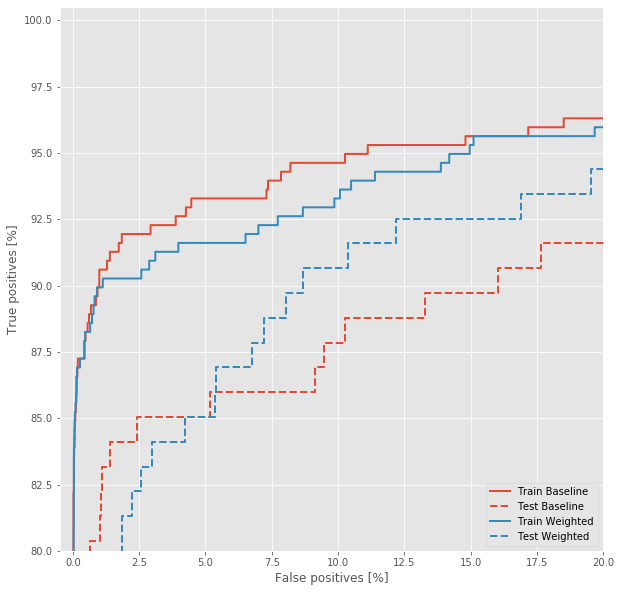

In [81]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

### 4.5 Oversampling  
소스 클래스의 비를 늘려서 balance를 맞춘후 학습시킨다.

In [82]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

positive 샘플을 무작이로 중복을 허용하고 더 뽑는다.

In [83]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

In [84]:
res_pos_features.shape

(181978, 29)

In [85]:
neg_features.shape

(181978, 29)

In [86]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

In [87]:
resampled_features.shape

(363956, 29)

#### tf.data 만들기

In [88]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [89]:
pos_ds

<RepeatDataset shapes: ((29,), ()), types: (tf.float64, tf.int64)>

한개 샘플만 추출해보기

In [90]:
for features, label in pos_ds.take(1):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())

Features:
 [-0.48518836  2.13563846 -4.26551301  3.49079091 -1.64254667 -1.73217901
 -4.69530726  1.14148988 -3.94279983 -5.          5.         -5.
 -0.31532957 -5.         -0.14800322 -5.         -5.         -4.5983848
  1.23907757  1.50756495  1.47286487 -0.71864567 -0.53648194 -0.66972574
  1.74814489  2.42176407  3.47142318  2.33982784 -4.85407094]

Label:  1


In [91]:
for features, label in pos_ds.take(2):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())

Features:
 [ 0.60166009  1.54250205 -3.30019329  3.80374532  0.73519338 -0.95191444
 -1.02078118  0.30423771 -2.38279979 -2.82957335  3.41364133 -3.7734063
 -0.59700575 -5.         -1.61395644 -0.47294245 -1.76255006  0.41649119
 -1.43317432  0.30205043  0.17027589 -0.98301739 -0.13823346 -1.5917509
  0.65260084  0.14258186  1.21764845  0.86085863 -0.66011663]

Label:  1
Features:
 [-0.62103387  2.99997905 -5.          5.         -0.12211896 -2.09197536
 -2.61882367  1.38441115 -3.98371928 -5.          4.02773163 -5.
  0.67642184 -5.          1.11757324 -2.43183452 -1.85448963  0.23512361
  0.61752701  0.79580686  0.73523622 -0.76730618  0.31709595 -1.15303358
  0.0480545   1.06978536  0.95644951 -0.16863484 -1.57844309]

Label:  1


tf.data의 주요설정에 대하여 간단하게 살펴보자.

- cache : preprocessing 시간이 너무 길어서 줄이고 싶을때 사용
- shuffle : 데이터 셔플링, 숫자를 데이터 갯수만큼 설정하면 완전히 랜덤하게 셔플링, 그 이상 설정해도 똑같음. 다만 적게 설정할경우 셔플링이 완전하게 잘 되지 않음  
- prefetch : 학습중일때, 데이터 로드시간을 줄이기 위해 미리 메모리에 적재시킴. 괄호안의 숫자는 얼마만큼 적재시킬지에 대한 숫자  
-  tf.data.experimental.AUTOTUNE : 네트워크가 알아서 데이터 정리  
  

dataset api를 사용하면, 데이터를 로드하는 bottleneck 시간이 줄어들게 되어서 학습시간이 줄어들게 되는 효과가 있음. 애초에 데이터가 크지 않아 bottleneck 시간이 적다면, 차이는 없을것같습니다.

- 참고자로 : https://github.com/taki0112/Tensorflow-DatasetAPI?fbclid=IwAR27Q9zMvHk4ftJN1TDZfCucVGw_-FlF0Axs7YP_RPEZVuPWtoqeVz3TsJU

`experimental.sample_from_datasets`을 사용하여 두 데이터셋을 병합

In [92]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [93]:
for features, label in resampled_ds.take(1):
    print(label.numpy())

[0 1 1 ... 1 0 1]


In [94]:
len(label.numpy())

2048

In [95]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.50537109375


- 밸런스가 맞다

tf.data 데이터 세트를 사용하려면 number of steps per epoch 정보가 필요하다.

이"에포크"의 정의는 명확하지 않기 때문이다. 각 nagative sample 예를 한 번 보는 데 필요한 배치 수라고 가정한다.

In [96]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

오버샘플링된 데이터 학습

In [97]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>

In [98]:
val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

In [99]:
resampled_history = resampled_model.fit(resampled_ds, epochs=EPOCHS,
                                        steps_per_epoch=resampled_steps_per_epoch,
                                        callbacks = [early_stopping], validation_data=val_ds)

Epoch 1/100
278/278 [==============================] - 5s 17ms/step - loss: 0.6971 - tp: 106975.6989 - fp: 31633.0036 - tn: 168766.6667 - fn: 36299.2903 - accuracy: 0.7989 - precision: 0.7285 - recall: 0.6725 - auc: 0.8459 - val_loss: 0.1866 - val_tp: 77.0000 - val_fp: 1051.0000 - val_tn: 44431.0000 - val_fn: 10.0000 - val_accuracy: 0.9767 - val_precision: 0.0683 - val_recall: 0.8851 - val_auc: 0.9734
Epoch 2/100
278/278 [==============================] - 3s 12ms/step - loss: 0.2092 - tp: 129776.5591 - fp: 8359.8638 - tn: 135009.7419 - fn: 13566.4946 - accuracy: 0.9208 - precision: 0.9361 - recall: 0.9032 - auc: 0.9718 - val_loss: 0.0983 - val_tp: 79.0000 - val_fp: 758.0000 - val_tn: 44724.0000 - val_fn: 8.0000 - val_accuracy: 0.9832 - val_precision: 0.0944 - val_recall: 0.9080 - val_auc: 0.9755
Epoch 3/100
278/278 [==============================] - 3s 12ms/step - loss: 0.1498 - tp: 131987.2366 - fp: 4946.5341 - tn: 138335.5305 - fn: 11443.3584 - accuracy: 0.9418 - precision: 0.9629 - 

Epoch 00020: early stopping


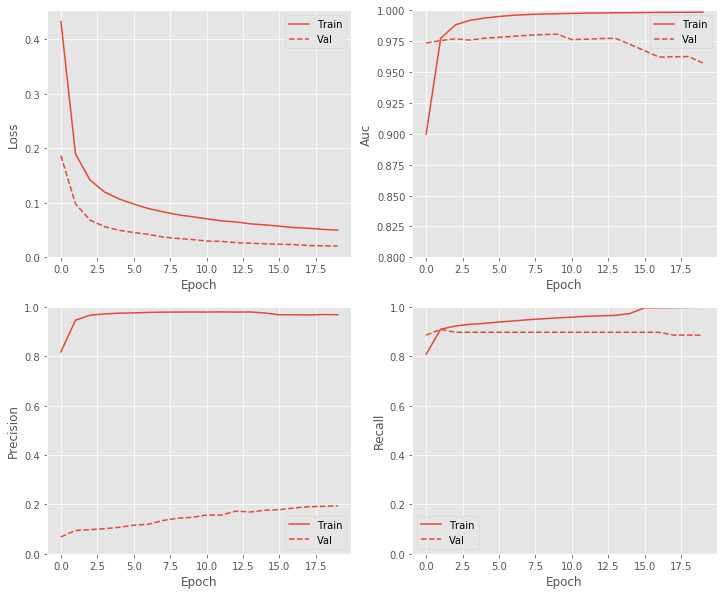

In [100]:
plot_metrics(resampled_history )

- 전체 데이터셋으로 그레디언트 업데이트에 사용한다면, 이 오버샘플링은 기본적으로 앞의 class weight를 한 fit과 동일하다.   
- 그런데 학습이 배체 단위로 실행되면(여기처럼), 오버샘플링 데이터는 부드러운 그래디언트 신호를 만든다. 앞의 예에서는 positive 샘플이 큰 가중치를 보이는 반면, 여기서는 각 샘플의 가중치가 상대적으로 작기 때문이다.  
- 이러한 부드러한 그래디언트 신호가 학습을 더 용이하게 한다.  
- validation, test 데이터의 분포가 다르기 때문에 metric 결과가 기존과 다르게 나타났다.

### 4.6 재학습

balanced data에서 학습이 쉽기 때문에, 앞의 예에서 학습과정은 overfitting이 쉽게 발생할 수가 있다.  
따라서 epoch들을 쪼개서 EarlyStopping 컬백이 미세조정을 할 수 있도록 한다.

In [101]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>

In [102]:
resampled_history = resampled_model.fit(resampled_ds,
                                        # These are not real epochs
                                        steps_per_epoch = 20, 
                                        epochs=10*EPOCHS, callbacks = [early_stopping], validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 2s 99ms/step - loss: 1.4702 - tp: 3794.2381 - fp: 3089.3810 - tn: 53552.9048 - fn: 7562.9524 - accuracy: 0.8532 - precision: 0.5214 - recall: 0.3149 - auc: 0.8274 - val_loss: 0.4630 - val_tp: 53.0000 - val_fp: 7555.0000 - val_tn: 37927.0000 - val_fn: 34.0000 - val_accuracy: 0.8335 - val_precision: 0.0070 - val_recall: 0.6092 - val_auc: 0.7732
Epoch 2/1000
20/20 [==============================] - 0s 19ms/step - loss: 0.8101 - tp: 6552.6190 - fp: 3191.0000 - tn: 8071.1905 - fn: 4615.6667 - accuracy: 0.6450 - precision: 0.6686 - recall: 0.5712 - auc: 0.6568 - val_loss: 0.4719 - val_tp: 75.0000 - val_fp: 7939.0000 - val_tn: 37543.0000 - val_fn: 12.0000 - val_accuracy: 0.8255 - val_precision: 0.0094 - val_recall: 0.8621 - val_auc: 0.9295
Epoch 3/1000
20/20 [==============================] - 0s 18ms/step - loss: 0.5755 - tp: 8108.1429 - fp: 3195.0000 - tn: 8095.5238 - fn: 3031.8095 - accuracy: 0.7169 - precision: 0.7106 - recall: 0.7188 -

Epoch 22/1000
20/20 [==============================] - 0s 16ms/step - loss: 0.1855 - tp: 10141.4762 - fp: 532.2381 - tn: 10748.3810 - fn: 1008.3810 - accuracy: 0.9304 - precision: 0.9500 - recall: 0.9074 - auc: 0.9784 - val_loss: 0.1227 - val_tp: 79.0000 - val_fp: 762.0000 - val_tn: 44720.0000 - val_fn: 8.0000 - val_accuracy: 0.9831 - val_precision: 0.0939 - val_recall: 0.9080 - val_auc: 0.9755
Epoch 23/1000
20/20 [==============================] - 0s 17ms/step - loss: 0.1811 - tp: 10218.4762 - fp: 494.7619 - tn: 10721.9524 - fn: 995.2857 - accuracy: 0.9335 - precision: 0.9543 - recall: 0.9110 - auc: 0.9795 - val_loss: 0.1173 - val_tp: 79.0000 - val_fp: 744.0000 - val_tn: 44738.0000 - val_fn: 8.0000 - val_accuracy: 0.9835 - val_precision: 0.0960 - val_recall: 0.9080 - val_auc: 0.9755
Epoch 24/1000
20/20 [==============================] - 0s 20ms/step - loss: 0.1722 - tp: 10228.1429 - fp: 490.9524 - tn: 10754.1429 - fn: 957.2381 - accuracy: 0.9358 - precision: 0.9541 - recall: 0.9149 - 

Epoch 43/1000
20/20 [==============================] - 0s 20ms/step - loss: 0.1305 - tp: 10378.2381 - fp: 341.8571 - tn: 10854.6667 - fn: 855.7143 - accuracy: 0.9467 - precision: 0.9677 - recall: 0.9242 - auc: 0.9899 - val_loss: 0.0668 - val_tp: 78.0000 - val_fp: 714.0000 - val_tn: 44768.0000 - val_fn: 9.0000 - val_accuracy: 0.9841 - val_precision: 0.0985 - val_recall: 0.8966 - val_auc: 0.9776
Epoch 44/1000
20/20 [==============================] - 0s 20ms/step - loss: 0.1279 - tp: 10319.3810 - fp: 340.0952 - tn: 10958.6190 - fn: 812.3810 - accuracy: 0.9485 - precision: 0.9681 - recall: 0.9270 - auc: 0.9906 - val_loss: 0.0654 - val_tp: 78.0000 - val_fp: 706.0000 - val_tn: 44776.0000 - val_fn: 9.0000 - val_accuracy: 0.9843 - val_precision: 0.0995 - val_recall: 0.8966 - val_auc: 0.9767
Epoch 45/1000
20/20 [==============================] - 0s 17ms/step - loss: 0.1267 - tp: 10456.0000 - fp: 324.9524 - tn: 10810.6190 - fn: 838.9048 - accuracy: 0.9479 - precision: 0.9705 - recall: 0.9248 - a

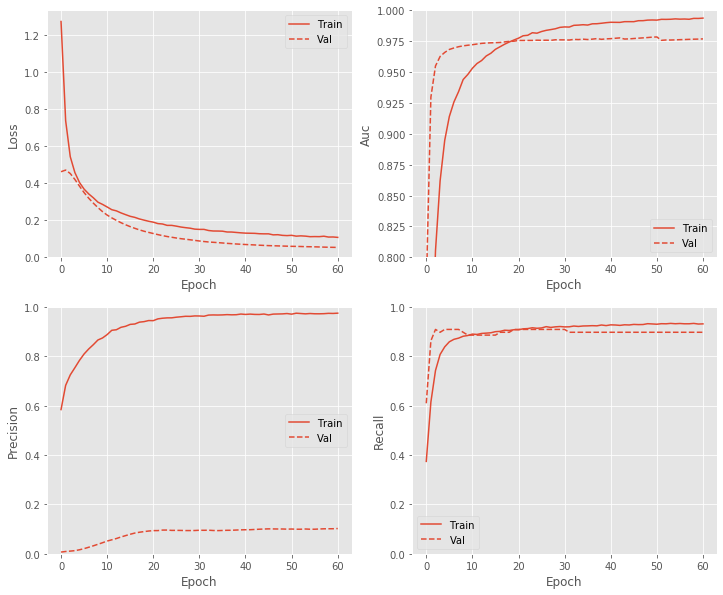

In [103]:
plot_metrics(resampled_history)

매트릭 평가

In [104]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

In [105]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

loss :  0.06183766573667526
tp :  87.0
fp :  906.0
tn :  55949.0
fn :  20.0
accuracy :  0.9837435483932495
precision :  0.0876132920384407
recall :  0.8130841255187988
auc :  0.9683583378791809



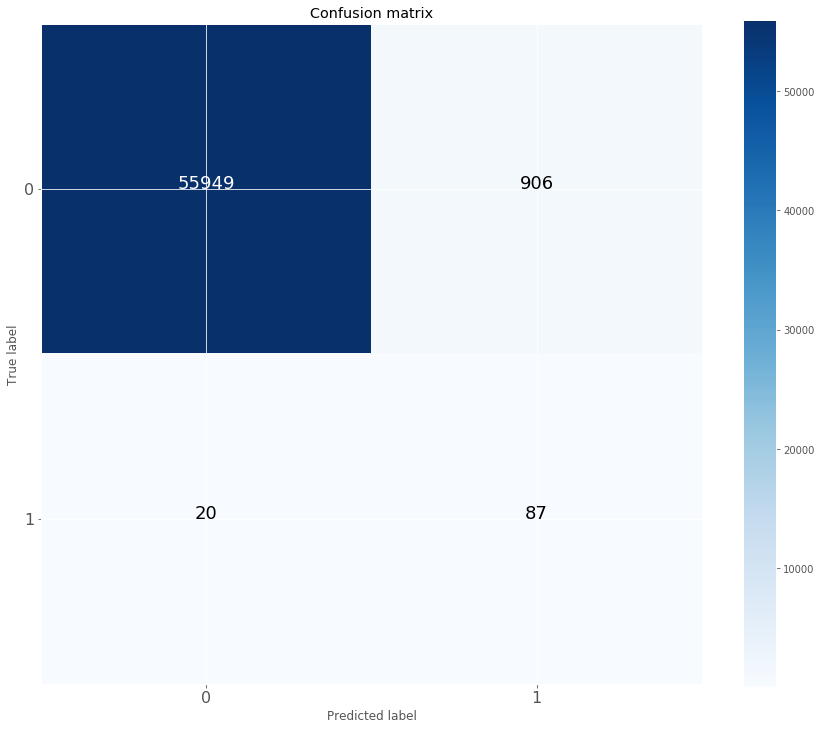

In [106]:
conf_mat = confusion_matrix(test_labels, test_predictions_resampled.flatten()>= 0.5)
class_names = [0,1]
plot_confusion_matrix(conf_mat , classes=class_names,
                      title='Confusion matrix')
plt.show()

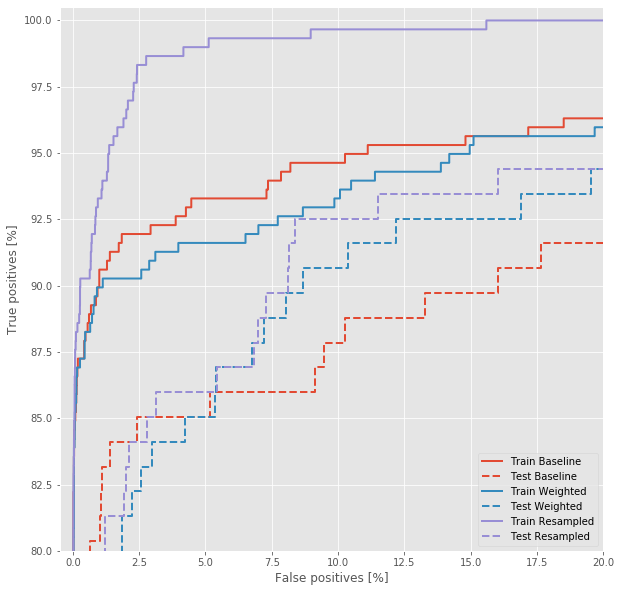

In [107]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right')

## 5. 정 리  
- 불균형 데이터를 다루는 것은 매우 어렵다. 왜냐하면 제한된 수량의 데이터로 학습을 해야하기 때문이다.  
- 따라서 가능한 많은 샘플을 수집하는데 노력해야하고, 이 것이 불가능 하다면 소수 클래스를 최대한 활용할 수 있도록 다양한 방법을 활용해야 한다.  
- 그리고 문제의 맥락과 다양한 유형의 오차간의 균형을 고려하여 모델을 설계해야 한다.